# Data 
Source: 'https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json'

Goal:    **Model email topics**

Explanations and theory: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# Load data and python libraries

In [1]:
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('max_colwidth',200)

import numpy as np
import collections

# text processing linraries
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_md 
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = en_core_web_md.load(disable=['parser', 'ner'])

# topic modeling libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import models, corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim 

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#progress meter for loops
from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm

In [2]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())

print('\nDataset size:', df.shape)
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']

Dataset size: (11314, 3)


,content,target,target_names
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if ...",7,rec.autos
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9...",4,comp.sys.mac.hardware
10,"From: irwin@cmptrc.lonestar.org (Irwin Arnstein)\nSubject: Re: Recommendation on Duc\nSummary: What's it worth?\nDistribution: usa\nExpires: Sat, 1 May 1993 05:00:00 GMT\nOrganization: CompuTrac I...",8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-Kun Chen)\nSubject: ** Software forsale (lots) **\nNntp-Posting-Host: magnusug.magnus.acs.ohio-state.edu\nOrganization: The Ohio State University\n ...,6,misc.forsale
1000,"From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\nSubject: Diamond SS24X, Win 3.1, Mouse cursor\nOrganization: National Library of Medicine\nLines: 10\n\n\nAnybody seen mouse cursor distortion running...",2,comp.os.ms-windows.misc


# Data Cleaning and Preporations

In [3]:
# data for analysis
df = df[df['content'].isnull() == False]
len(df)

11314

In [4]:
#content text example
print(df['content'].iloc[104])

From: markm@bigfoot.sps.mot.com (Mark Monninger)
Subject: Re: No-Haggle Deals...Save $$???
Nntp-Posting-Host: 223.250.10.7
Reply-To: rapw20@email.sps.mot.com
Organization: SPS
Distribution: usa
Lines: 3

You can be sure they wouldn't do it if it wasn't to their advantage.

Mark



In [5]:
df['content'].iloc[104]

"From: markm@bigfoot.sps.mot.com (Mark Monninger)\nSubject: Re: No-Haggle Deals...Save $$???\nNntp-Posting-Host: 223.250.10.7\nReply-To: rapw20@email.sps.mot.com\nOrganization: SPS\nDistribution: usa\nLines: 3\n\nYou can be sure they wouldn't do it if it wasn't to their advantage.\n\nMark\n"

In [6]:
print('Every email has subject:')
df['content'].str.contains('Subject: ').value_counts()

Every email has subject:


True    11314
Name: content, dtype: int64

In [7]:
#extract Subject of each email
df['subject'] = df['content'].str.split('Subject: ').str.get(1)
df['subject'] = df['subject'].str.replace(r'\n+.+','')
print('Extracted subject example:\n', '='*30 + '\n', df['subject'].iloc[104])
print('='*30)

#check that all subjects where extracted
print('An email has extracted subject:')
(df['subject'].isnull() == False).value_counts()

Extracted subject example:
 Re: No-Haggle Deals...Save $$???

An email has extracted subject:


True    11314
Name: subject, dtype: int64

In [8]:
#extract text of each email
print('Every email has words "Lines: ":')
df['content'].str.contains('Lines: ').value_counts()

Every email has words "Lines: ":


True     11276
False       38
Name: content, dtype: int64

In [9]:
#extract text of each email
df['text'] = df['content'].str.split(r'Lines: \d+').str.get(1)
print('Extracted subject example:\n', '='*30 + '\n', df['text'].iloc[104])
print('='*30)

#check that all texts where extracted
print('An email has extracted text:')
(df['text'].isnull() == False).value_counts()

Extracted subject example:
 

You can be sure they wouldn't do it if it wasn't to their advantage.

Mark

An email has extracted text:


True     11273
False       41
Name: text, dtype: int64

In [10]:
#delete records with no extracted text of email
df = df[df['text'].isnull() == False]
len(df)

11273

In [11]:
#spot check
print(df[df['text'].str.contains('@') == True]['text'].iloc[0])


NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>



In [12]:
# additional text cleaning

# remove text related to "Posting-Host"
df['text'] = df['text'].str.replace(r'NNTP-Posting-Host: \S*\s?', '', re.I)

# remove Emails
df['text'] = df['text'].str.replace(r'\S*@\S*\s?', '')

# remove new line characters
df['text'] = df['text'].str.replace(r'\s+', ' ')

# remove single quotes
df['text'] = df['text'].str.replace(r"\'", '')

In [13]:
#spot check
print('Message text contains emails:')
df['text'].str.contains('@').value_counts()

Message text contains emails:


False    11273
Name: text, dtype: int64

In [14]:
# add message subject to the message text for topic modeling
df['text'] = df['subject'] + '\n' + df['text']

In [15]:
# review text length analysis
df['Text Length in Characters'] = df['text'].apply(len)

print("Text Length in Characters:")
df['Text Length in Characters'].describe()

Text Length in Characters:


count    11273.000000
mean      1605.498359
std       3437.286153
min          7.000000
25%        535.000000
50%        919.000000
75%       1574.000000
max      64788.000000
Name: Text Length in Characters, dtype: float64

In [16]:
del df['Text Length in Characters']

In [17]:
#split the sample on two fpr training and testing the model
split_ind = 100

df_data = df.iloc[:-split_ind]
df_test_data = df.iloc[-split_ind:]

len(df), len(df_data), len(df_test_data)

(11273, 11173, 100)

# Data Preprocessing

In [18]:
# create spacy "nlp" object
df_data['doc'] = df_data['text'].apply(lambda x: nlp(x))

# delete stop words, select POSs that are letters and correspond to words with atleast 3 characters 
df_data['list_of_POSs'] = df_data['doc'].apply(lambda x: [word.pos_
                                    for word in x if (word.is_stop==False) & (len(word.text)>2) & (word.is_alpha)])

##### Selecting most informative POSs by total frequencies

In [19]:
# POS is more about the context of the features than frequencies of features

# get all POSs in each review in a list
tmp_list = df_data['list_of_POSs'].tolist()
list_of_POSs = [POS for sublist in tmp_list for POS in sublist]

#count POSs' total frequencies in the corpus
POS_freq_counter = collections.Counter(list_of_POSs)
s_POS_freq = pd.Series(POS_freq_counter)

#sort POSs document frequencies in the corpus 
s_tmp = s_POS_freq.sort_values(ascending=False)

print('Total number of POSs: ', len(set(s_POS_freq)))
print('POS = ADP means conjunction, subordinating or preposition')
print('POS = INTJ means interjection')
pd.DataFrame(s_tmp, columns=['Frequency'])

Total number of POSs:  16
POS = ADP means conjunction, subordinating or preposition
POS = INTJ means interjection


,Frequency
NOUN,526937
VERB,278089
PROPN,266981
ADJ,154997
ADV,43796
ADP,5646
INTJ,5183
X,3475
NUM,1212
CCONJ,376


In [20]:
#selecting POSs
selected_POSs = ['NOUN', 'VERB', 'ADJ', 'ADV']

print('selecting POSs:')
selected_POSs 

selecting POSs:


['NOUN', 'VERB', 'ADJ', 'ADV']

##### Selecting most informative lemmas by document frequencies

In [21]:
# lemmatize words with selected POSs, 
# lemmas that are not stop-words and have atleast 3 characters
df_data['list_of_lemmas'] = df_data['doc'].apply(lambda x: [word.lemma_
                                                                for word in x if (word.is_stop==False) & \
                                                                                 (len(word.text)>2) & \
                                                                                 (word.is_alpha) & \
                                                                                 (word.pos_ in selected_POSs)])

In [22]:
# example of an email
ind = 3

print(df_data['text'].iloc[ind])
print('\n#Lemmas:\n')
print(df_data['list_of_lemmas'].iloc[ind])

set_POSs = set(df_data['list_of_POSs'].apply(set).iloc[ind])
print('\n#POSs:\n')
print(set_POSs)
print('Only lemmas with POSs:', set_POSs & set(selected_POSs), ' were selected')

** Software forsale (lots) **

 1. Software publishing SuperBase 4 windows v.1.3 --->$80 2. OCR System ReadRight v.3.1 for Windows --->$65 3. OCR System ReadRight v.2.01 for DOS --->$65 4. Unregistered Zortech 32 bit C++ Compiler v.3.1 --->$ 250 with Multiscope windows Debugger, WhiteWater Resource Toolkit, Library Source Code 5. Glockenspiel/ImageSoft Commonview 2 Windows Applications Framework for Borland C++ --->$70 6. Spontaneous Assembly Library With Source Code --->$50 7. Microsoft Macro Assembly 6.0 --->$50 8. Microsoft Windows v.3.1 SDK Documentation --->$125 9. Microsoft FoxPro V.2.0 --->$75 10. WordPerfect 5.0 Developers Toolkit --->$20 11. Kedwell Software DataBoss v.3.5 C Code Generator --->$100 12. Kedwell InstallBoss v.2.0 Installation Generator --->$35 13. Liant Software C++/Views v.2.1 Windows Application Framework with Source Code --->$195 14. IBM OS/2 2.0 & Developers Toolkit --->$95 15. CBTree DOS/Windows Library with Source Code --->$120 16. Symantec TimeLine for Wi

In [23]:
# reducing dimentionality of word dictionary in LDA model
# lemmas with higher document frequencies are more likely to appear in the extracted topics

# get all unique lemmas from each review in a list
tmp_list = df_data['list_of_lemmas'].apply(set).apply(list).tolist()
list_of_lemmas = [lemma for sublist in tmp_list for lemma in sublist]

#count lemmas' document frequencies in the corpus
lemma_freq_counter = collections.Counter(list_of_lemmas)
s_lemma_freq = pd.Series(lemma_freq_counter)

#analyse lemmas' document frequencies in the corpus 
s_tmp = s_lemma_freq.sort_values(ascending=False)
df_tmp = pd.DataFrame({'Most freq words': list(s_tmp.index[:20]),
                       'M_freq': list(s_tmp.iloc[:20]),
                       'Least freq words': list(s_tmp.index[-20:]),
                       'L_freq': list(s_tmp.iloc[-20:])})

print('Total number of unique lemmas: ', len(s_lemma_freq))
print ("\nDistribution of lemmas' document counts: ")
print(s_lemma_freq.describe(percentiles=[0.55, 0.65, 0.75, 0.85, 0.95, 0.97, 0.99]))
df_tmp

Total number of unique lemmas:  32097

Distribution of lemmas' document counts: 
count    32097.000000
mean        21.187619
std        108.348629
min          1.000000
50%          2.000000
55.0%        2.000000
65%          4.000000
75%          7.000000
85%         16.000000
95%         82.000000
97%        144.000000
99%        393.040000
max       6406.000000
dtype: float64


,Most freq words,M_freq,Least freq words,L_freq
0,write,6406,incompatibly,1
1,article,4875,verifie,1
2,know,3756,xtapperror,1
3,think,3207,exitworkproc,1
4,good,2758,excape,1
5,time,2667,registre,1
6,people,2429,windowless,1
7,use,2340,decrement,1
8,want,2286,pericynthion,1
9,work,2219,toneau,1


In [24]:
# select lemmas with document count between 50% and 99th persentile
up_pst = s_lemma_freq.quantile(0.99)
low_pst = 5 #s_lemma_freq.quantile(0.50)

selected_lemmas = set(s_lemma_freq[(s_lemma_freq > low_pst)&(s_lemma_freq < up_pst)].index)
print ('Upper bound for lemma document frecuency: ', up_pst)
print ('Lower bound for lemma document frecuency: ', low_pst)
print('Number of selected lemmas: ', len(selected_lemmas))

print("\nExample of selected lemmas:")
list(selected_lemmas)[:5]

Upper bound for lemma document frecuency:  393.0400000000009
Lower bound for lemma document frecuency:  5
Number of selected lemmas:  8885

Example of selected lemmas:


['reputation', 'clinical', 'proof', 'meta', 'entail']

In [25]:
# select lemmas in each document if they belong to chosen list of lemmas
df_data['selected_list_of_lemmas'] = df_data['list_of_lemmas'].apply(lambda x: 
                                                                     [l for l in x if l in selected_lemmas])

In [26]:
# example of an email
ind = 3

print(df_data['text'].iloc[ind])
print('\n#Selected lemmas:\n')
print(df_data['selected_list_of_lemmas'].iloc[ind])

** Software forsale (lots) **

 1. Software publishing SuperBase 4 windows v.1.3 --->$80 2. OCR System ReadRight v.3.1 for Windows --->$65 3. OCR System ReadRight v.2.01 for DOS --->$65 4. Unregistered Zortech 32 bit C++ Compiler v.3.1 --->$ 250 with Multiscope windows Debugger, WhiteWater Resource Toolkit, Library Source Code 5. Glockenspiel/ImageSoft Commonview 2 Windows Applications Framework for Borland C++ --->$70 6. Spontaneous Assembly Library With Source Code --->$50 7. Microsoft Macro Assembly 6.0 --->$50 8. Microsoft Windows v.3.1 SDK Documentation --->$125 9. Microsoft FoxPro V.2.0 --->$75 10. WordPerfect 5.0 Developers Toolkit --->$20 11. Kedwell Software DataBoss v.3.5 C Code Generator --->$100 12. Kedwell InstallBoss v.2.0 Installation Generator --->$35 13. Liant Software C++/Views v.2.1 Windows Application Framework with Source Code --->$195 14. IBM OS/2 2.0 & Developers Toolkit --->$95 15. CBTree DOS/Windows Library with Source Code --->$120 16. Symantec TimeLine for Wi

# Create document-term matrix for the LDA model 

In [27]:
# create a vocabulary for the LDA model 
dictionary = corpora.Dictionary(df_data['selected_list_of_lemmas'])

In [28]:
print('Number of texts processed: ', dictionary.num_docs)
print('Number of extracted tokens/words: ', len(dictionary.token2id))
print('\nEach text is represented by list of ', len(dictionary.token2id), 
      " tuples: \n\t\t(token's index in bag-of-words dictionary, token's term frequesncy)")

Number of texts processed:  11173
Number of extracted tokens/words:  8885

Each text is represented by list of  8885  tuples: 
		(token's index in bag-of-words dictionary, token's term frequesncy)


In [29]:
# count the number of occurrences of each distinct token in aech document
df_data['doc2bow'] = df_data['selected_list_of_lemmas'].apply(lambda x: dictionary.doc2bow(x))
df_data[['selected_list_of_lemmas','doc2bow']].head()

,selected_list_of_lemmas,doc2bow
0,"[enlighten, sport, door, addition, bumper, separate, body, model, engine, spec, production, history, funky, neighborhood]","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]"
1,"[fair, brave, soul, upgrade, clock, oscillator, share, poll, brief, detail, procedure, attain, cpu, rate, adapter, heat, sink, hour, usage, floppy, functionality, floppy, request, summarize, netwo...","[(14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1..."
10,"[recommendation, model, clock, paint, brown, orange, fade, leak, oil, pop, shop, fix, tran, oil, leak, bike, owner, stable, mate, bike, honk, dod]","[(8, 1), (18, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1)]"
100,"[forsale, publish, unregistered, spontaneous, documentation, installation, negotiable]","[(56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1)]"
1000,"[diamond, cursor, Anybody, mouse, cursor, distortion, indication, menu, deliver]","[(63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1)]"


In [30]:
#create document-term matrix for LDA
doc_term_matrix = list(df_data['doc2bow'].values)

# Estimate the number of topics in a corpus (through topic coherence)

In [43]:
LDA = models.LdaMulticore
num_topics_list = np.arange(3,36)

coherenceList_cv = []


#for each number of topics calculate Coherence Score
for num_topics in tqdm(num_topics_list):
    #LDA model
    lda= LDA(corpus=doc_term_matrix, num_topics=num_topics, id2word = dictionary, 
             passes=20,chunksize=4000,random_state=3,workers=2)
    
    #C_v coherence score
    cm_cv = CoherenceModel(model=lda, corpus=doc_term_matrix,
                           texts=df_data['selected_list_of_lemmas'], dictionary=dictionary, coherence='c_v')
    
    #append model coherence value 
    coherenceList_cv.append(cm_cv.get_coherence())

100%|██████████| 33/33 [41:03<00:00, 76.92s/it]


Text(0.5, 1.05, 'Topic Coherence\n  C_v Score')

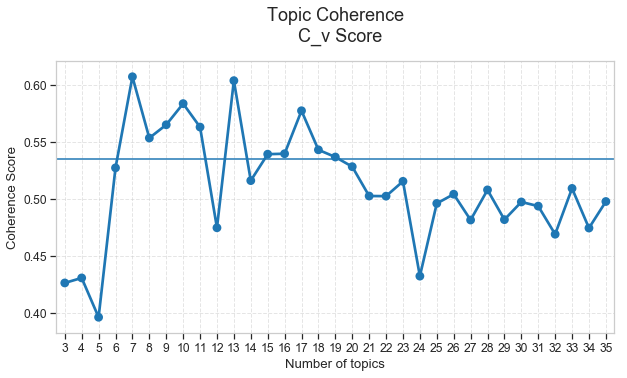

In [44]:
df_plot = pd.DataFrame({'Number of topics':num_topics_list,
                         'Coherence Score':coherenceList_cv})
f, ax = plt.subplots(figsize=(10, 5))
plt.style.use('seaborn-whitegrid')

sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 1.5})
sns.pointplot(x ='Number of topics', y = 'Coherence Score', data=df_plot)

plt.axhline(y=0.535)

ax.grid(True, ls='--', alpha=0.5)
plt.title('Topic Coherence\n  C_v Score', y=1.05, fontsize=18)

# Define multicore LDA model

In [46]:
# define the model with chosen number of topics
num_topics = 20


LDA = models.LdaMulticore
lda_model= LDA(corpus=doc_term_matrix, 
               num_topics=num_topics,
               id2word = dictionary, 
               passes=20,
               chunksize=4000,
               random_state=3)

In [37]:
# compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     corpus=doc_term_matrix,
                                     texts=df_data['selected_list_of_lemmas'], 
                                     dictionary=dictionary, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5005664443973549


In [47]:
cm_cv = CoherenceModel(model=lda_model, corpus=doc_term_matrix,
                       texts=df_data['selected_list_of_lemmas'], dictionary=dictionary, coherence='c_v')
coherence_model_lda.get_coherence()

0.5005664443973549

##### Interactive visualization of topics using pyLDAviz

In [48]:
doc2bow = df_data['doc2bow'].iloc[10]
doc2bow 

[(184, 2),
 (185, 1),
 (186, 3),
 (187, 1),
 (188, 1),
 (189, 1),
 (190, 1),
 (191, 1),
 (192, 1),
 (193, 1),
 (194, 1),
 (195, 1),
 (196, 1),
 (197, 1),
 (198, 1),
 (199, 1)]

In [49]:
print(df_data['text'].iloc[10])

Re: Fractal Generation of Clouds


 (Frederick J. Haab) writes: >I need to implement an algorithm to fractally generate clouds >as sort of a benchmark for some algorithms Im working on. Just as a matter of interest, a self-promo computer graphics sequence that one of the local TV stations used to play quite a lot a couple of years ago showed a 3D flyover of Australia from the West coast to the East. The clouds were quite recognisable as fuzzy, flat, white Mandlebrot sets!! David Silver 


In [50]:
print(df_data['selected_list_of_lemmas'].iloc[10]) #1, 13

['fractal', 'generation', 'cloud', 'implement', 'algorithm', 'generate', 'cloud', 'benchmark', 'algorithm', 'interest', 'self', 'graphic', 'sequence', 'station', 'coast', 'cloud', 'fuzzy', 'flat', 'white']


In [51]:
for index, score in sorted(lda_model[doc2bow], key=lambda tup: -1*tup[1]):
    print("Score: ", round(score, 2)," Topic: ", lda_model.print_topic(index, 7))

Score:  0.53  Topic:  0.032*"image" + 0.014*"format" + 0.014*"graphic" + 0.013*"package" + 0.012*"color" + 0.011*"site" + 0.010*"ftp"
Score:  0.42  Topic:  0.022*"weapon" + 0.013*"firearm" + 0.009*"criminal" + 0.009*"crime" + 0.008*"rate" + 0.007*"helmet" + 0.007*"handgun"


In [52]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary,sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.230255  0.039607       1        1  5.054791
1      0.227758  0.054693       2        1  7.486696
2      0.079562  0.019396       3        1  2.222378
3      0.104306  0.051592       4        1  6.140469
4     -0.090066  0.022929       5        1  5.657607
5     -0.100880  0.018695       6        1  8.768559
6      0.111083  0.046311       7        1  4.929569
7     -0.127710  0.024879       8        1  4.654855
8     -0.048227  0.002474       9        1  4.185633
9     -0.105819  0.007957      10        1  3.822720
10     0.220975  0.045411      11        1  5.642883
11    -0.146699  0.002104      12        1  8.271286
12     0.068451 -0.447109      13        1  1.208342
13    -0.063105  0.011632      14        1  3.132671
14    -0.004510  0.008887      15        1  5.155053
15    -0.039733  0.026405      16        1  4.479791
16    -0.073295  0.010223      17        1  3.249864
17    -0.110251  0.017254      18        1  4.138430
18     0.023751  0.030685      19        1  5.234029
19    -0.155845  0.005973      20        1  6.564380, topic_info=     Category         Freq         Term        Total  loglift  logprob
1975  Default  3746.000000          max  3746.000000  30.0000  30.0000
925   Default  1076.000000        image  1076.000000  29.0000  29.0000
1742  Default   933.000000       player   933.000000  28.0000  28.0000
289   Default   759.000000   encryption   759.000000  27.0000  27.0000
2234  Default   769.000000       server   769.000000  26.0000  26.0000
1160  Default   599.000000       weapon   599.000000  25.0000  25.0000
39    Default   671.000000         bike   671.000000  24.0000  24.0000
2724  Default   621.000000      turkish   621.000000  23.0000  23.0000
1545  Default   598.000000      israeli   598.000000  22.0000  22.0000
2659  Default   540.000000     armenian   540.000000  21.0000  21.0000
2655  Default   453.000000       widget   453.000000  20.0000  20.0000
163   Default   581.000000          god   581.000000  19.0000  19.0000
766   Default   527.000000        entry   527.000000  18.0000  18.0000
2152  Default   610.000000       format   610.000000  17.0000  17.0000
1492  Default   680.000000     religion   680.000000  16.0000  16.0000
146   Default   502.000000      atheist   502.000000  15.0000  15.0000
2356  Default   412.000000        trade   412.000000  14.0000  14.0000
193   Default   562.000000      graphic   562.000000  13.0000  13.0000
764   Default   836.000000        color   836.000000  12.0000  12.0000
768   Default   606.000000      monitor   606.000000  11.0000  11.0000
1802  Default   786.000000      display   786.000000  10.0000  10.0000
2144  Default   435.000000   controller   435.000000   9.0000   9.0000
984   Default   635.000000       season   635.000000   8.0000   8.0000
150   Default   552.000000       belief   552.000000   7.0000   7.0000
685   Default   544.000000       period   544.000000   6.0000   6.0000
1487  Default   549.000000        faith   549.000000   5.0000   5.0000
117   Default   745.000000      package   745.000000   4.0000   4.0000
238   Default   463.000000         ride   463.000000   3.0000   3.0000
1004  Default   437.000000        moral   437.000000   2.0000   2.0000
2939  Default   477.000000       launch   477.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
5892  Topic20    29.175243     casualty    38.668179   2.4418  -7.1111
3738  Topic20    48.311680      bombing    72.876404   2.3124  -6.6068
3627  Topic20    37.188469  citizenship    52.961555   2.3699  -6.8685
2259  Topic20   196.416168         land   457.743011   1.8774  -5.2042
3596  Topic20    55.446388   occupation    90.169495   2.2372  -6.4690
245   Topic20   218.371521          war   574.291870   1.7566  -5.0983
3176  Topic20    38.304970        bless    57.064651   2.3249  -6.8389
2727  Topic20   114.40

##### Comparing with known topics

In [ ]:
df_data.columns

In [ ]:
def top_topic(doc2bow, lda_model):

    for index, score in sorted(lda_model[doc2bow], key=lambda tup: -1*tup[1]):
        print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

In [ ]:
df_data['infered_topics'] = df_data['doc2bow'].apply(lambda d: sorted(lda_model(d),key=lambda x:x[1],reverse=True))

# Topic evaluation: selection of important topics

In [ ]:
# get topic ID and corresponding topic words
dict_topics = dict(ldamallet.show_topics(num_topics=num_topics,formatted=False,num_words=10))

df_topics = pd.DataFrame({'topic': list(dict_topics.keys()), 
                          'topic words': list(dict_topics.values())}, index=range(len(dict_topics)))

df_topics['topic'] = df_topics['topic'].apply(lambda x: 'Topic ' + str(x + 1))
df_topics['topic words'] = df_topics['topic words'].apply(lambda x: str(list(dict(x).keys())))
df_topics

In [ ]:
# get topic words and topic average cohearance score
list_tmp = ldamallet.top_topics(doc_term_matrix, dictionary=dictionary, topn=10, coherence='c_v', texts=df_data['list_of_lemmas'])
list_tmp = [(s,wd) for (wd, s) in list_tmp]
dict_scores = dict(list_tmp)
df_scores = pd.DataFrame({'topic coherence score': list(dict_scores.keys()), 
                          'topic words': list(dict_scores.values())}, index=range(len(dict_scores)))
df_scores['topic words'] = df_scores['topic words'].apply(lambda x: str(list(dict(x).values())))
df_scores.head()

In [ ]:
# add topic score to the df_topics to distinguish between human interpretable topics and jargons of statistical analysis
# Higher the topic coherence, the topic is more human interpretable. 
print('Can assign names to the topics based on the words related to each topic:')
df_topics = df_topics.merge(df_scores, on='topic words')
df_topics.sort_values(by='topic coherence score',ascending=False,inplace=True)
df_topics

# Determine what topic a given document is about
find the topic number that has the highest percentage contribution in that document.

In [ ]:
# create spacy "nlp" object
df_new_data['doc'] = df_new_data['text'].apply(lambda x: nlp(x))

In [ ]:
df_new_data['selected_list_of_lemmas'] = df_new_data['doc'].apply(lambda x: [word.lemma_
                                                                for word in x if (word.pos_ in selected_POSs) & \
                                                                                 (word.lemma_ in selected_lemmas)
                                                                   ])
df_new_data['doc2bow'] = df_new_data['selected_list_of_lemmas'].apply(lambda x: dictionary.doc2bow(x))

df_new_data['topics'] = df_new_data['doc2bow'].apply(lambda d: sorted(ldamallet(d),key=lambda x:x[1],reverse=True))